In [2]:
# ---------------- processing Raman files exported from Peakfit

    # - This code was developed in close collaboration with Valeria Fonseca Díaz and Marco Dalla Vecchia, and would not exist without their help!
    
# --- import modules

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from matplotlib.collections import LineCollection


# --- set working directories

base_dir = "./_DATA/Raman/"


In [54]:
# --- function to import data from spectrum and peak files and create a combined dataframe

def spectrum_data(spectrum_file):
    
    # --- PART 1: import spectrum data from input file and create a spectrum dataframe

        # --- set file name to be processed
    current_mineral = spectrum_file.replace(".dat", "").replace(".txt", "")

            # --- get input file and save as a spectrum dataframe

    df_spectrum = pd.read_csv(base_dir+"spectra/"+spectrum_file, header=None, skiprows=1, sep='\s+',
                             names=['XY', 'X Value', 'Y Value', 'Y Predict', 'Residual', 'Residual%', '90% Confidence', 'Limits', '90% Prediction', 'Limits2', 'Weights'])

    df_spectrum = df_spectrum.drop(columns=['XY']) 
        
        # --- add file information
    df_spectrum.insert(0,'file',current_mineral)
    
    
#     return df_spectrum
       
       

    # --- PART 2: get corresponding peak information from input file 
         
    separator = " "

        # --- get lines from processed peak file

    current_peak = open(base_dir+"peaks/"+current_mineral+'_peaks.txt', "r")
    original_current_lines = current_peak.readlines()
    current_lines = []

    for line in original_current_lines:
        partial_lines = line.split("  ")
        while "" in partial_lines:
            partial_lines.remove("")
        str_line = ""
        for item in partial_lines:
            str_line = str_line + item.replace(" ","")+ separator
        current_lines.append(str_line)

        # --- get values from lines

    counter = 0

    for line in current_lines:
        if "r^2CoefDet" in line:
            break
        counter+=1

    r2 = current_lines[counter+1].split(separator)[0]

        # --- get total number of peaks from last peak entry, at the end of peak file

    counter = 0

    for line in current_lines[::-1]:
        if "Peak" in line:
            peak_line = line
            break

    total_peaks = peak_line.split(separator)
    peak_number = int(total_peaks[0].replace("Peak",""))
    peak_number

        # --- get positions of overall tables

    counter = 0
    peaks_tables_loc = []

    for line in current_lines:
        if "Peak"+separator in line:
            peaks_tables_loc.append(counter)
        counter += 1

        # --- grab data per peak for each table

    peaks_dict = {}

    for ii in range(peak_number):
        peaks_dict[str(ii+1)] = {}

    for line_counter in peaks_tables_loc:    
        current_attributes = current_lines[line_counter].split(separator)

        for iii in range(line_counter+1,(line_counter+peak_number+1)):
            split_line = current_lines[iii].split(separator)

            kk=0

            for attribute in current_attributes: 

                peaks_dict[str(iii-(line_counter))][attribute.replace("\n","")] = split_line[kk].replace("\n","")
                kk+=1

            # --- final peak table

    df_peaks = pd.DataFrame.from_dict(peaks_dict, orient="index")

    df_peaks.drop("",axis=1,inplace=True)

    df_peaks["r2"] = r2
    df_peaks["mineral"] = current_mineral

    #return df_peaks

          

    # --- PART 3: combine peak parameters with spectrum dataframe

    df_spectrum_peaks = df_spectrum.copy()

        # --- create tuples that will receive each peak parameter

    wv_range = np.array(df_spectrum["X Value"])
    current_center_range = np.zeros(df_spectrum.shape[0])
    current_height_range = np.zeros(df_spectrum.shape[0])
    current_fwhm_range = np.zeros(df_spectrum.shape[0])
    current_a0_range = np.zeros(df_spectrum.shape[0])
    current_a1_range = np.zeros(df_spectrum.shape[0])
    current_a2_range = np.zeros(df_spectrum.shape[0])
    current_a3_range = np.zeros(df_spectrum.shape[0])
    

        # --- copy peak parameters from peak dataframe


    peak_parameters = df_peaks[['Center','Amplitude','FWHM','a0','a1','a2','a3']].astype(float) 
    # here a float conversion is needed because df_peaks has only strings, and np.where condition will compare wv_range numbers
    
   
        # --- loop through peaks in peak dataframe to copy and assign values to tuples created

    for peak, value in peak_parameters['Center'].iteritems():    
        current_center_range[np.where(wv_range>=value)[0][0]] = value
        current_height_range[np.where(wv_range>=value)[0][0]] = peak_parameters['Amplitude'][peak]
        current_fwhm_range[np.where(wv_range>=value)[0][0]] = peak_parameters['FWHM'][peak]
        current_a0_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a0'][peak]
        current_a1_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a1'][peak]
        current_a2_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a2'][peak]
        current_a3_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a3'][peak]
              
        
        # --- assign tuples with peak parameters as columns in the spectra dataframe

    df_spectrum_peaks["center"] = current_center_range
    df_spectrum_peaks["height"] = current_height_range
    df_spectrum_peaks["FWHM"] = current_fwhm_range
    df_spectrum_peaks["G/L"] = current_a3_range
    df_spectrum_peaks["a0"] = current_a0_range
    df_spectrum_peaks["a1"] = current_a1_range
    df_spectrum_peaks["a2"] = current_a2_range
    df_spectrum_peaks["a3"] = current_a3_range
    df_spectrum_peaks["R2"] = r2

    
        # --- Convert 'a' parameters to numeric for later calculations
    df_spectrum_peaks['a0'] = pd.to_numeric(df_spectrum_peaks['a0'])
    df_spectrum_peaks['a1'] = pd.to_numeric(df_spectrum_peaks['a1'])
    df_spectrum_peaks['a2'] = pd.to_numeric(df_spectrum_peaks['a2'])
    df_spectrum_peaks['a3'] = pd.to_numeric(df_spectrum_peaks['a3'])

    #df_spectrum_peaks.to_csv('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+current_mineral+".csv",index = None)
    return df_spectrum_peaks





# --- function to plot curves with the Gaussian+Lorentzian sum profile

def gauss_lor_sum(x, a_0, a_1, a_2, a_3):
    return (a_0*(((((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))*(np.exp(-4*np.log(2)*(((x-a_1)/a_2)**2))))+((1-a_3)/(np.pi*a_2*(1+(4*(((x-a_1)/a_2)**2))))))/
                 (((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))+((1-a_3)/(np.pi*a_2)))))


# Gaussian-Lorentzian Sum (Amplitude) - Peakfit:

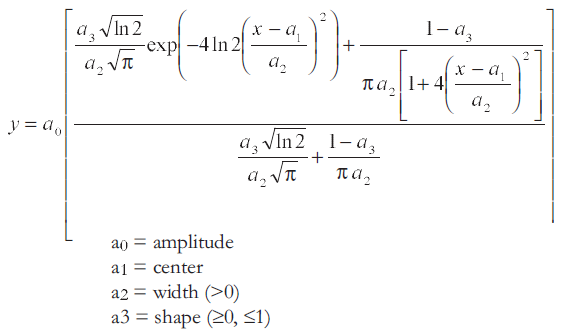

In [59]:
# --- get list of files

spectra_files = sorted(os.listdir(base_dir+"spectra"))

peak_files = sorted(os.listdir(base_dir+"peaks"))

print(spectra_files,
      "\n",len(spectra_files),
      "\n\n",
    peak_files,
      "\n",len(peak_files),)

['CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat', 'CGM_bu04-ore2-mid-gray_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat', 'CGM_bu19ts-coltan3-core_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat', 'CGM_bu19ts-coltan3-rim_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat', 'CGM_bu24-ore1_150 (500nm)_633nm_edge_25%_x100_vis_swd_h30um_30sx2.dat', 'CGM_bu24-ore3-top-grain_150 (500nm)_633nm_edge_100%_x100_vis_swd_h30um_10sx2.dat', 'rutile_bu02a-area1-top-rutile-opaq2_150 (500nm)_633nm_edge_50%_x50_vis_lwd_h100um_10sx2.dat', 'rutile_bu04-ore2-bright_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat', 'rutile_bu19ts(1)-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat', 'rutile_bu19ts(1)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat', 'rutile_bu19ts(2)-ore2-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat', 'rutile_bu19ts(2)-ore2-core_1800 (450-850nm)_532nm_edge_10%_x100_vis_swd_h30um_60sx2.dat',

In [60]:
    # --- select one file from the spectra dataset to work with

#ff = 1
ff = spectra_files.index('CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat')

print(peak_files[ff])
print(spectra_files[ff])

df_spectrum_peaks = spectrum_data(spectra_files[ff])

df_spectrum_peaks

CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2_peaks.txt
CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat


,file,X Value,Y Value,Y Predict,Residual,Residual%,90% Confidence,Limits,90% Prediction,Limits2,Weights,center,height,FWHM,G/L,a0,a1,a2,a3,R2
0,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,103.924,0.000000,6.895860,-6.895860,0.000000,5.756372,8.035347,-4.650043,18.441763,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
1,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,108.546,5.586203,9.163157,-3.576954,-64.031930,7.470850,10.855463,-2.450342,20.776655,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
2,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,113.165,10.394402,13.343644,-2.949242,-28.373370,9.919168,16.768120,1.354629,25.332659,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
3,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,117.782,26.479457,23.414168,3.065290,11.576104,16.153536,30.674799,9.822766,37.005570,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
4,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,122.394,49.033842,47.837475,1.196367,2.439880,39.126893,56.548058,33.419303,62.255647,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,984.613,0.041225,8.743833,-8.702608,-21100.000000,8.191268,9.296398,-2.758983,20.246649,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
201,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,988.807,-0.018874,8.176945,-8.195819,43420.000000,7.655860,8.698030,-3.324401,19.678291,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
202,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,993.000,-0.089082,7.665481,-7.754562,8704.998100,7.173135,8.157826,-3.834599,19.165561,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267
203,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,997.190,-0.098383,7.202502,-7.300885,7420.850900,6.736462,7.668542,-4.296482,18.701486,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99885267


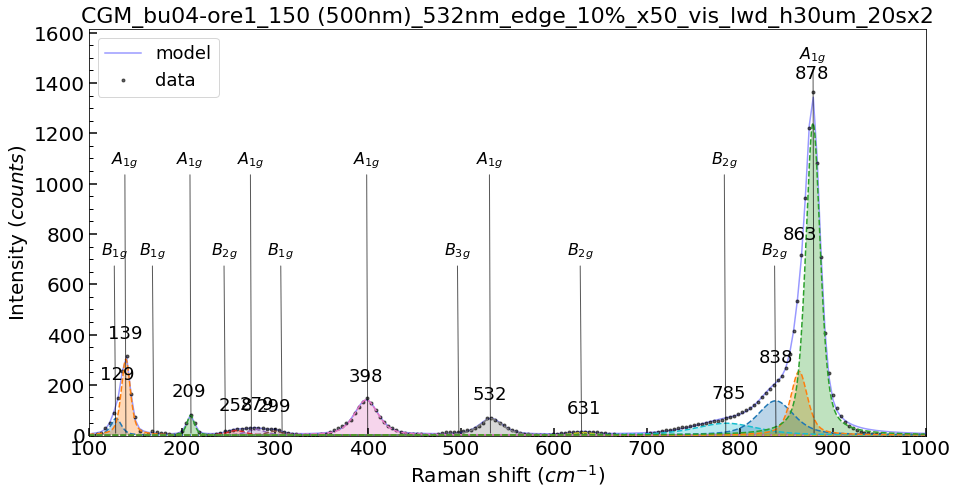

In [62]:
# --- make plot of single spectrum file

    # - set start and end for the plot x axis 

start = 100 
end = 1000

fig, ax = plt.subplots(figsize=(15,7.5))

    # --- RUTILE - add specific annotations for normal modes in the spectrum

# plt.annotate("$B_{1g}$",xy=(143, 0), xytext=(126, np.percentile(df_spectrum_peaks["Y Value"], 90)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$E_{g}$",xy=(447, 0), 
#              xytext=(437, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$A_{1g}$",xy=(612, 0), 
#              xytext=(597, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$B_{2g}$",xy=(826, 0), xytext=(810, np.percentile(df_spectrum_peaks["Y Value"], 90)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.text(240, np.percentile(df_spectrum_peaks["Y Value"], 91), 
#             "Second order \nphonons",horizontalalignment='center',fontsize=16)

    # --- COLTAN - add specific annotations for normal modes in the spectrum

plt.annotate("$A_{1g}$",xy=(880, 0), 
             xytext=(864, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 88)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(630, 0), 
             xytext=(614, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(532, 0), 
             xytext=(516, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(400, 0), 
             xytext=(384, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(275, 0), 
             xytext=(259, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(129, 0), 
             xytext=(113, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(140, 0), 
             xytext=(124, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(210, 0), 
             xytext=(194, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(785, 0), 
             xytext=(769, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(839, 0), 
             xytext=(823, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(170, 0), 
             xytext=(154, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(247, 0), 
             xytext=(231, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(308, 0), 
             xytext=(292, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{3g}$",xy=(498, 0), 
             xytext=(482, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

    # - plot the raw spectrum line (measured data) and the modelled spectrum (after peak fitting)

plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Predict"],'b-', label='model', alpha=0.4)
plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Value"],'k.', label='data', alpha=0.6)


    # - plot the modelled center value (Raman shift) of peaks above the curve.
            # plotting the FWHM is also possible by using the commented section   
    
for ii in range(df_spectrum_peaks.shape[0]):
    if start < df_spectrum_peaks.iloc[ii]["center"] < end:
        text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
        plt.text(df_spectrum_peaks.iloc[ii]["X Value"]-20,
                 df_spectrum_peaks.iloc[ii]["Y Predict"]+np.percentile(df_spectrum_peaks["Y Predict"], 80),
                 text,fontsize=18)
#         if np.percentile(df_spectrum_peaks.iloc[ii]["height"], 50) > df_spectrum_peaks.iloc[ii]["center"]:
#             text = str(int(df_spectrum_peaks.iloc[ii]["FWHM"]))
#             plt.text(df_spectrum_peaks.iloc[ii]["X Value"]-15,df_spectrum_peaks.iloc[ii]["Y Predict"]+10,text,fontsize=18)
   
    # - get positions of peak data inside the overall file
    
counter = 0
peak_lines_loc = []

for value in df_spectrum_peaks['center']:
    if value > 0:
        peak_lines_loc.append(counter)
    counter += 1

    
    # --- add modelled peaks to plot
    
x = np.arange(start,end)

for peak in peak_lines_loc:
    a_0 = df_spectrum_peaks['height'][peak]
    a_1 = df_spectrum_peaks['a1'][peak]
    a_2 = df_spectrum_peaks['a2'][peak]
    a_3 = df_spectrum_peaks['a3'][peak]
    y = gauss_lor_sum(x, a_0, a_1, a_2, a_3)
    plt.plot(x,y,ls='--')
    ax.fill_between(x, y.min(),y, alpha=0.3)
        
        
    # --- adjust plot parameters

plt.legend(loc='best',fontsize=18)    
    
plt.xlabel("Raman shift ($cm^{-1}$)",fontsize=20)
plt.xlim([start,end])
plt.ylabel("Intensity ($counts$)",fontsize=20)
plt.ylim([-5,np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 94)])

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(axis='both', which='major',labelsize=20,direction='in',width=1.5,length=8)
ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

plt.title(df_spectrum_peaks.iloc[0]["file"],horizontalalignment='center',fontsize=22)

# plt.text(start+150, np.percentile(df_spectrum_peaks["Y Value"], 100), 
#             "$R^2$="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=20)


        
# plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+df_spectrum_peaks.iloc[0]["file"]+'_peakfit.pdf')
plt.show()

In [63]:
df_spectra = pd.DataFrame()

for ii in range(len(spectra_files)):
    print(spectra_files[ii])
#     print(ii)
    df_a = spectrum_data(spectra_files[ii])
    df_a = df_a.drop(['Residual%','90% Confidence', 'Limits', '90% Prediction', 'Limits2', 
                      'Weights','a0', 'a1', 'a2', 'a3'],axis=1)
#     print(a.columns)
#     df_a
    df_spectra = pd.concat([df_spectra,df_a], axis=0, sort=False)
    
    #--- separate file information into relavant acquisition parameters
    
df_spectra[['mineral','sample','grating','laser','edge',
             'filter','objective','vis','lwd','pinhole',
             'acquisition']]=df_spectra["file"].str.split(pat='_', expand=True)

df_spectra = df_spectra.drop(['edge','vis','lwd'], axis=1)
    
    
    
df_spectra.to_csv('NTO-Raman_data.csv',index = True)
df_spectra

CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat
CGM_bu04-ore2-mid-gray_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat
CGM_bu19ts-coltan3-core_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat
CGM_bu19ts-coltan3-rim_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat
CGM_bu24-ore1_150 (500nm)_633nm_edge_25%_x100_vis_swd_h30um_30sx2.dat
CGM_bu24-ore3-top-grain_150 (500nm)_633nm_edge_100%_x100_vis_swd_h30um_10sx2.dat
rutile_bu02a-area1-top-rutile-opaq2_150 (500nm)_633nm_edge_50%_x50_vis_lwd_h100um_10sx2.dat
rutile_bu04-ore2-bright_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat
rutile_bu19ts(1)-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat
rutile_bu19ts(1)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat
rutile_bu19ts(2)-ore2-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat
rutile_bu19ts(2)-ore2-core_1800 (450-850nm)_532nm_edge_10%_x100_vis_swd_h30um_60sx2.dat
rutile_bu19ts(2)-ore2-rim_150 (500nm

,file,X Value,Y Value,Y Predict,Residual,center,height,FWHM,G/L,R2,mineral,sample,grating,laser,filter,objective,pinhole,acquisition
0,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,103.924,0.000000,6.895860,-6.895860,0.0,0.0,0.0,0.0,0.99885267,CGM,bu04-ore1,150 (500nm),532nm,10%,x50,h30um,20sx2
1,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,108.546,5.586203,9.163157,-3.576954,0.0,0.0,0.0,0.0,0.99885267,CGM,bu04-ore1,150 (500nm),532nm,10%,x50,h30um,20sx2
2,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,113.165,10.394402,13.343644,-2.949242,0.0,0.0,0.0,0.0,0.99885267,CGM,bu04-ore1,150 (500nm),532nm,10%,x50,h30um,20sx2
3,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,117.782,26.479457,23.414168,3.065290,0.0,0.0,0.0,0.0,0.99885267,CGM,bu04-ore1,150 (500nm),532nm,10%,x50,h30um,20sx2
4,CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_v...,122.394,49.033842,47.837475,1.196367,0.0,0.0,0.0,0.0,0.99885267,CGM,bu04-ore1,150 (500nm),532nm,10%,x50,h30um,20sx2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,rutile_bu19w-ore2-b-core_150 (500nm)_532nm_edg...,1014.130,8.883676,6.325050,2.558626,0.0,0.0,0.0,0.0,0.99964533,rutile,bu19w-ore2-b-core,150 (500nm),532nm,10%,x50,h30um,30sx2
207,rutile_bu19w-ore2-b-core_150 (500nm)_532nm_edg...,1018.310,7.875893,6.041716,1.834177,0.0,0.0,0.0,0.0,0.99964533,rutile,bu19w-ore2-b-core,150 (500nm),532nm,10%,x50,h30um,30sx2
208,rutile_bu19w-ore2-b-core_150 (500nm)_532nm_edg...,1022.490,6.743673,5.786247,0.957426,0.0,0.0,0.0,0.0,0.99964533,rutile,bu19w-ore2-b-core,150 (500nm),532nm,10%,x50,h30um,30sx2
209,rutile_bu19w-ore2-b-core_150 (500nm)_532nm_edg...,1026.660,5.630573,5.555634,0.074938,0.0,0.0,0.0,0.0,0.99964533,rutile,bu19w-ore2-b-core,150 (500nm),532nm,10%,x50,h30um,30sx2


CGM_bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat


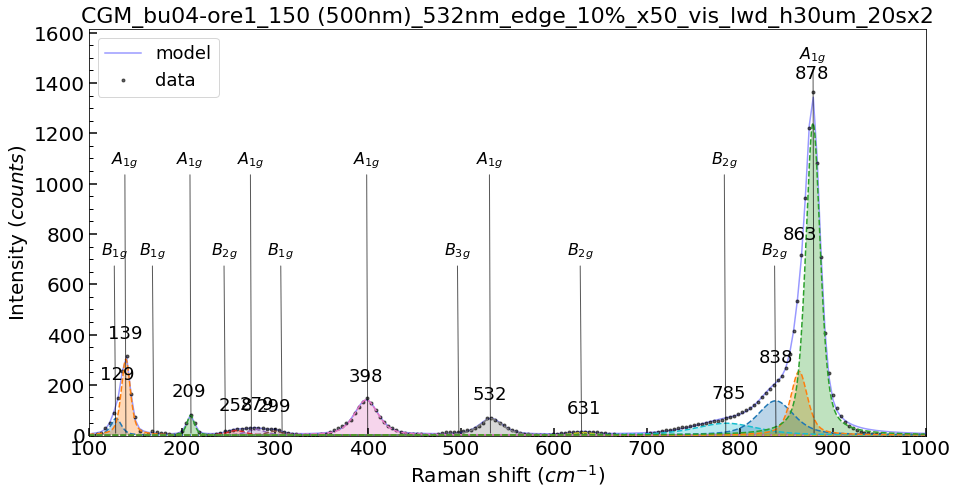

CGM_bu04-ore2-mid-gray_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat


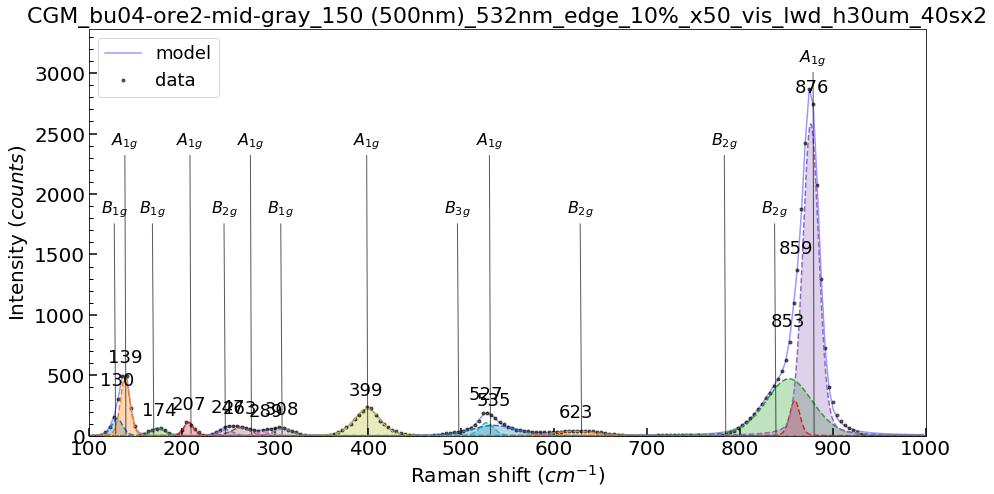

CGM_bu19ts-coltan3-core_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat


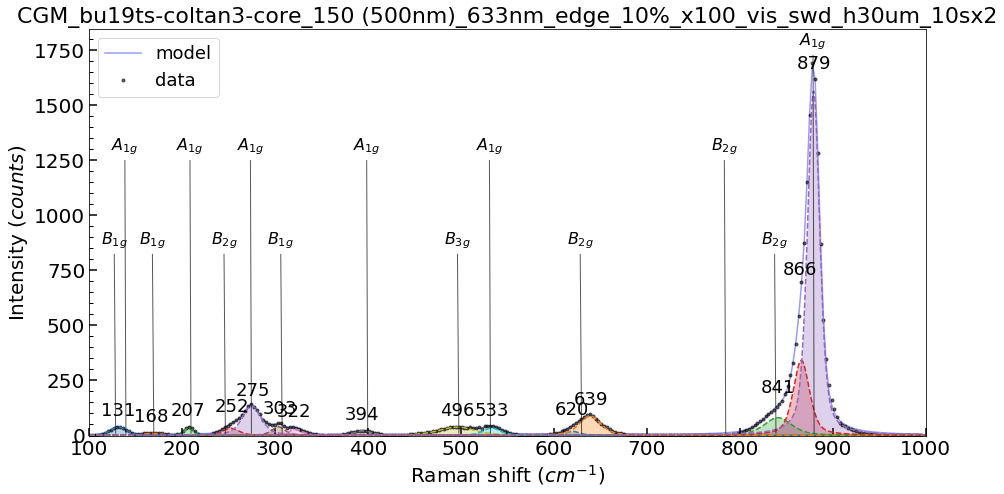

CGM_bu19ts-coltan3-rim_150 (500nm)_633nm_edge_10%_x100_vis_swd_h30um_10sx2.dat


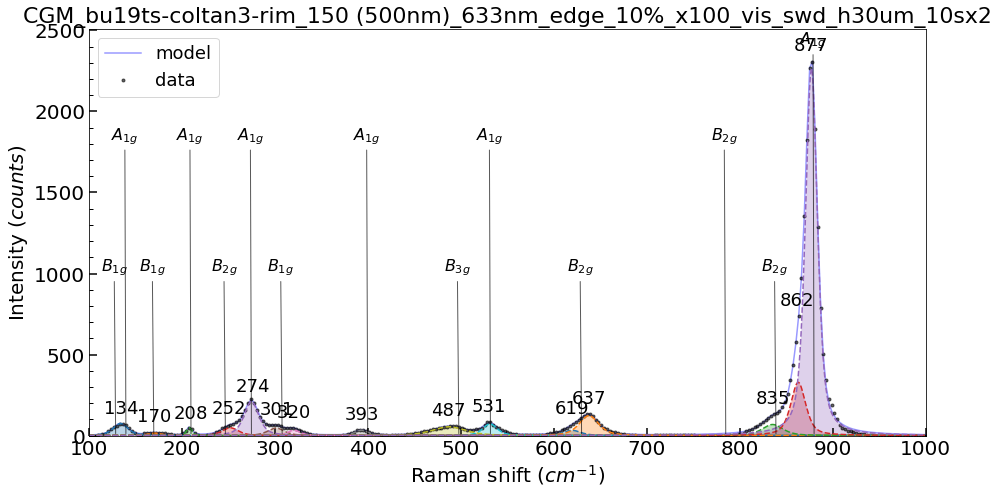

CGM_bu24-ore1_150 (500nm)_633nm_edge_25%_x100_vis_swd_h30um_30sx2.dat


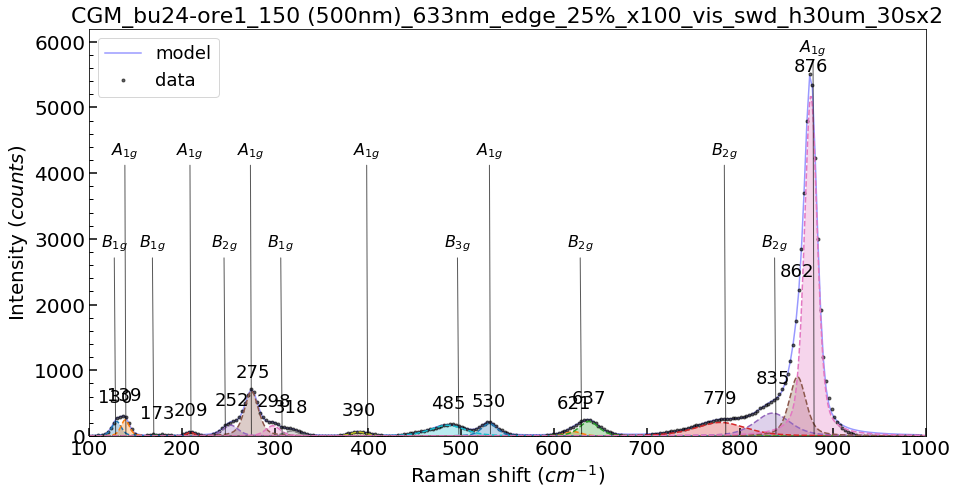

CGM_bu24-ore3-top-grain_150 (500nm)_633nm_edge_100%_x100_vis_swd_h30um_10sx2.dat


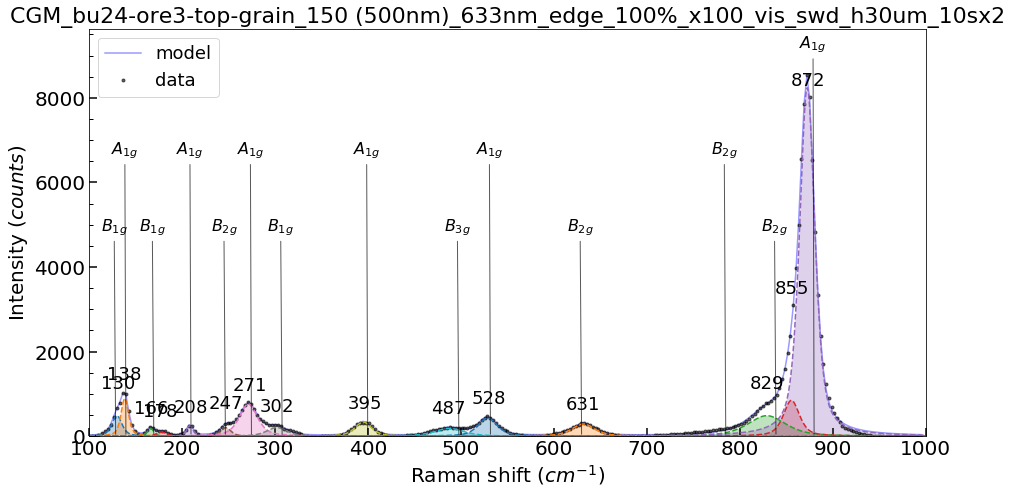

rutile_bu02a-area1-top-rutile-opaq2_150 (500nm)_633nm_edge_50%_x50_vis_lwd_h100um_10sx2.dat


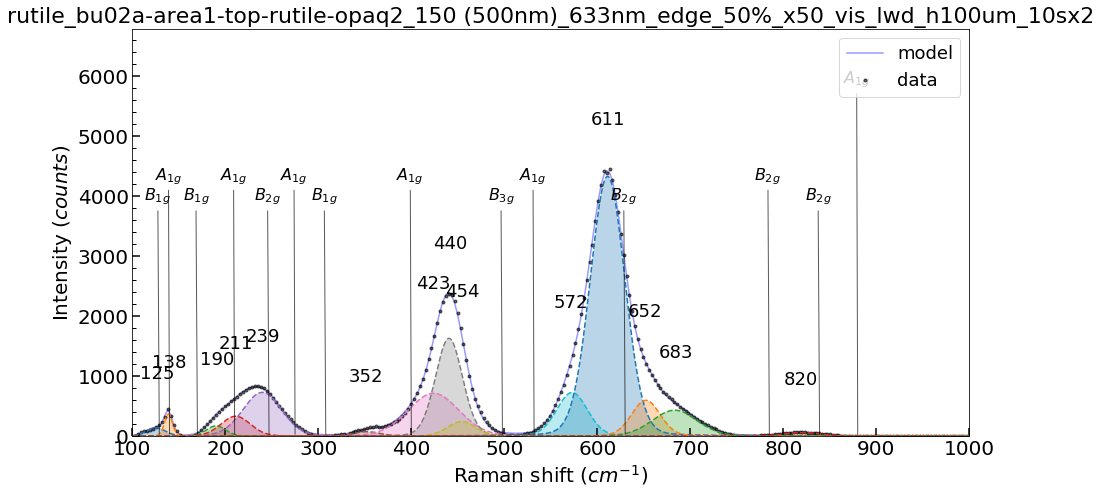

rutile_bu04-ore2-bright_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_40sx2.dat


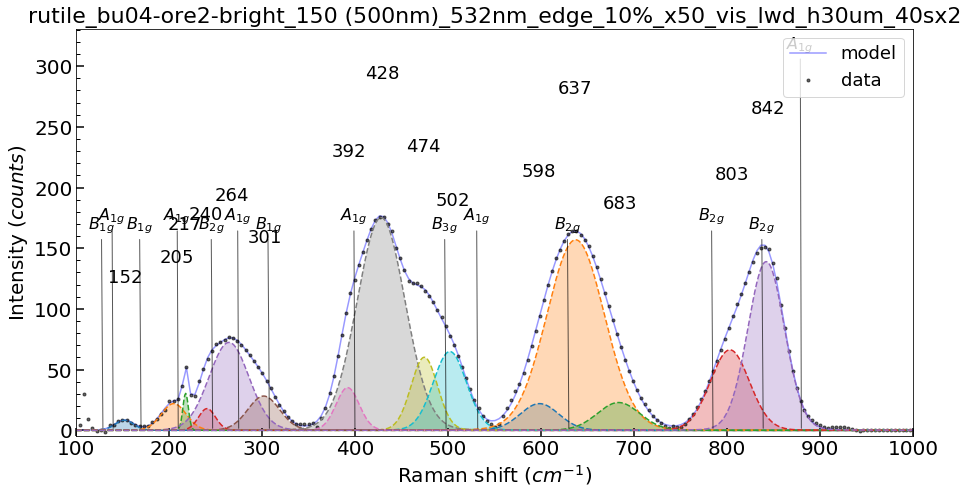

rutile_bu19ts(1)-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat


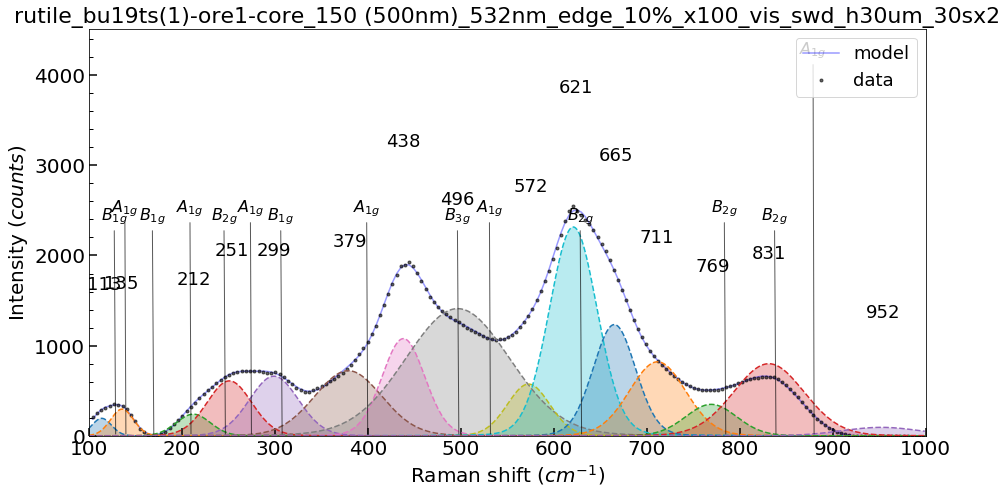

rutile_bu19ts(1)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat


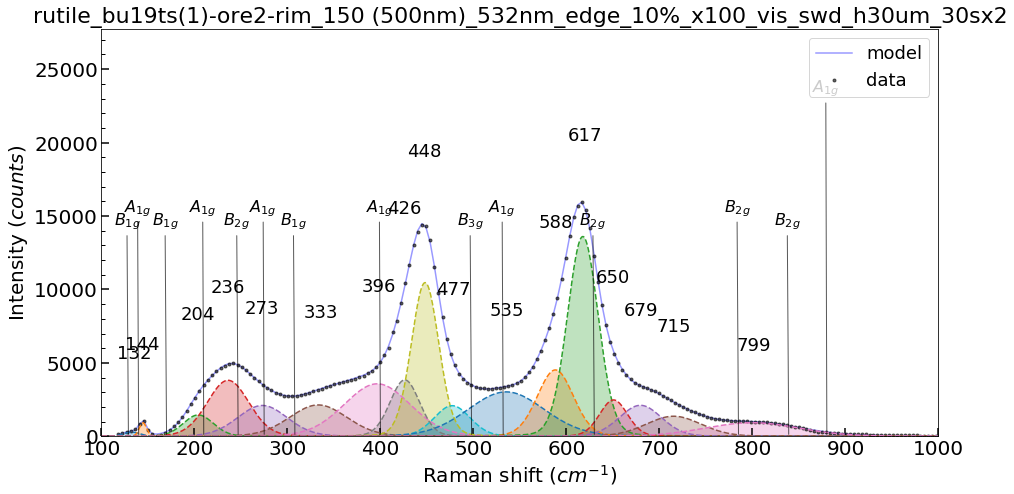

rutile_bu19ts(2)-ore2-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat


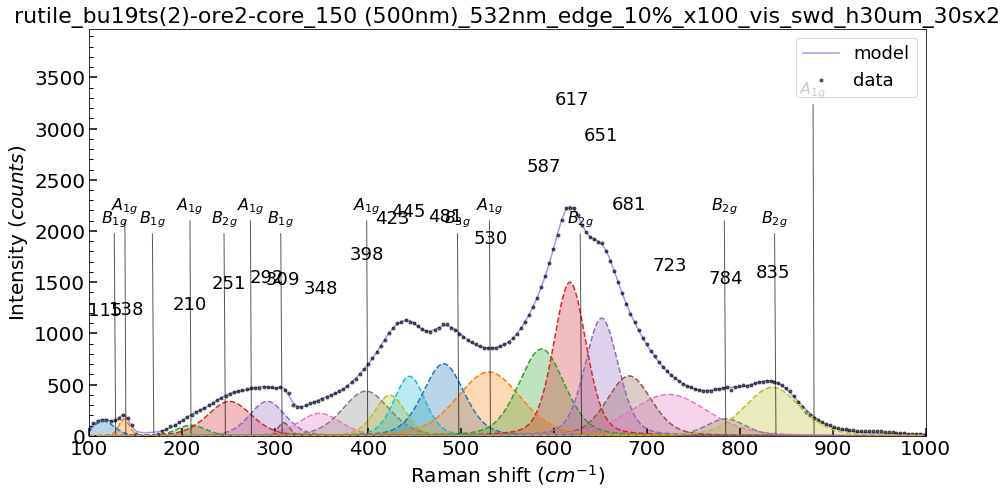

rutile_bu19ts(2)-ore2-core_1800 (450-850nm)_532nm_edge_10%_x100_vis_swd_h30um_60sx2.dat


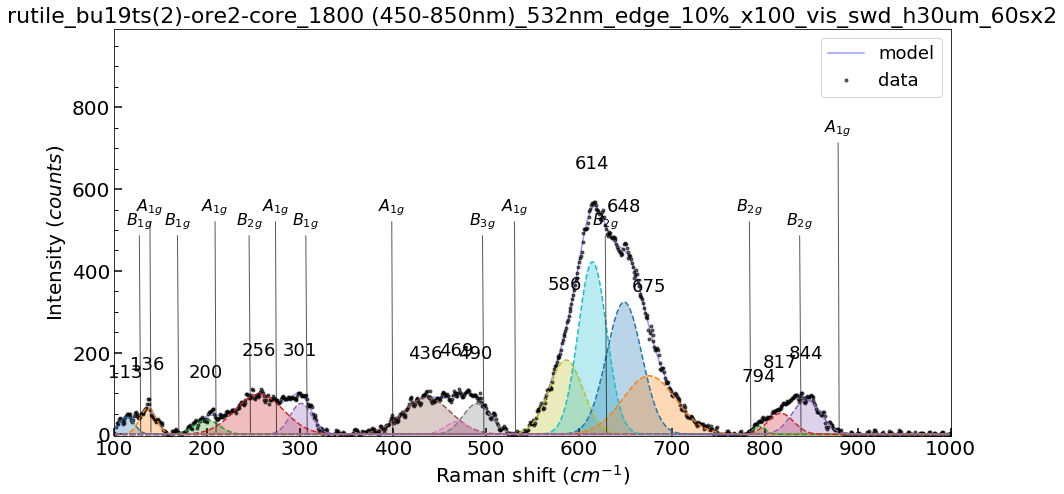

rutile_bu19ts(2)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat


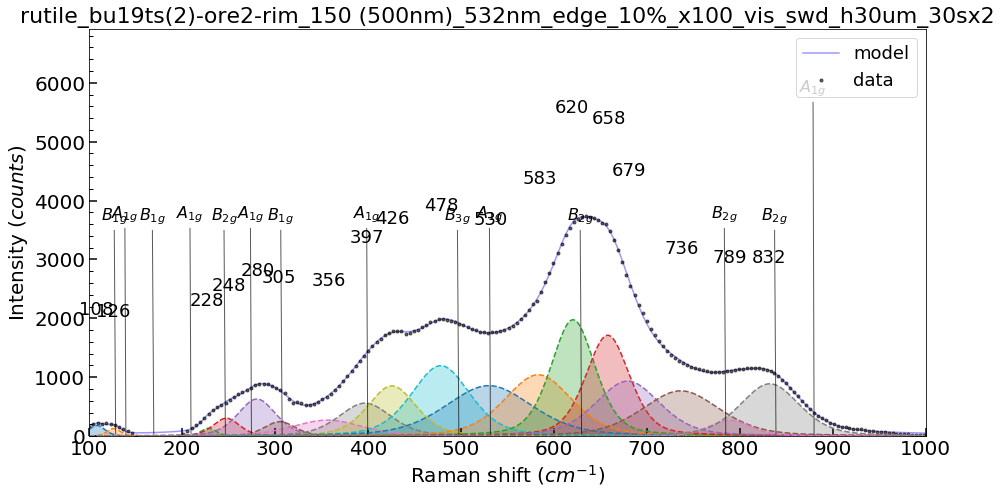

rutile_bu19ts(2)-ore2-rim_1800 (450-850nm)_532nm_edge_10%_x100_vis_swd_h30um_60sx2.dat


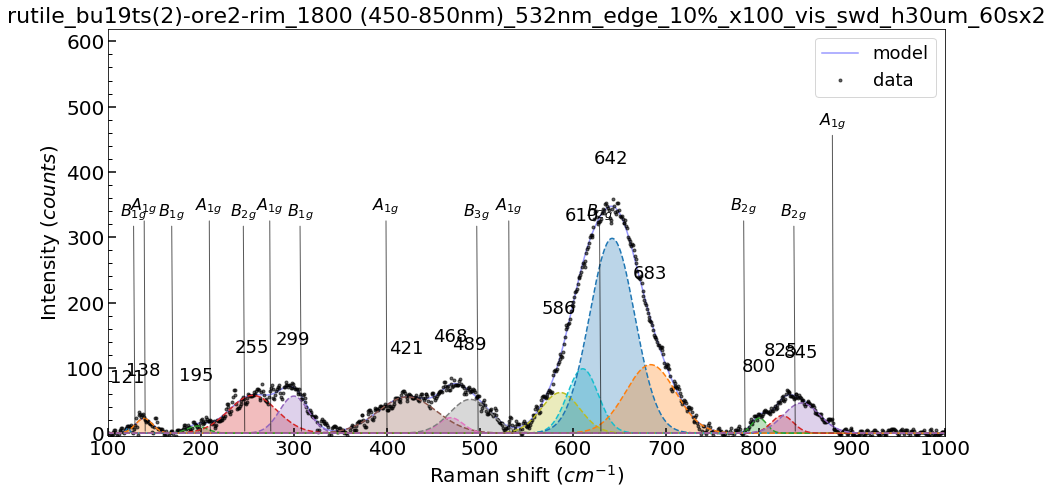

rutile_bu19w-ore2-a_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2.dat


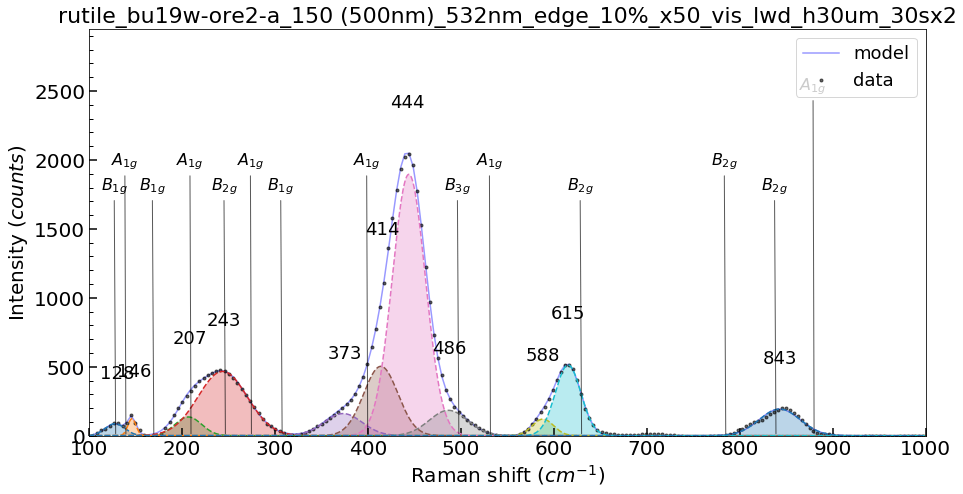

rutile_bu19w-ore2-b-core_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2.dat


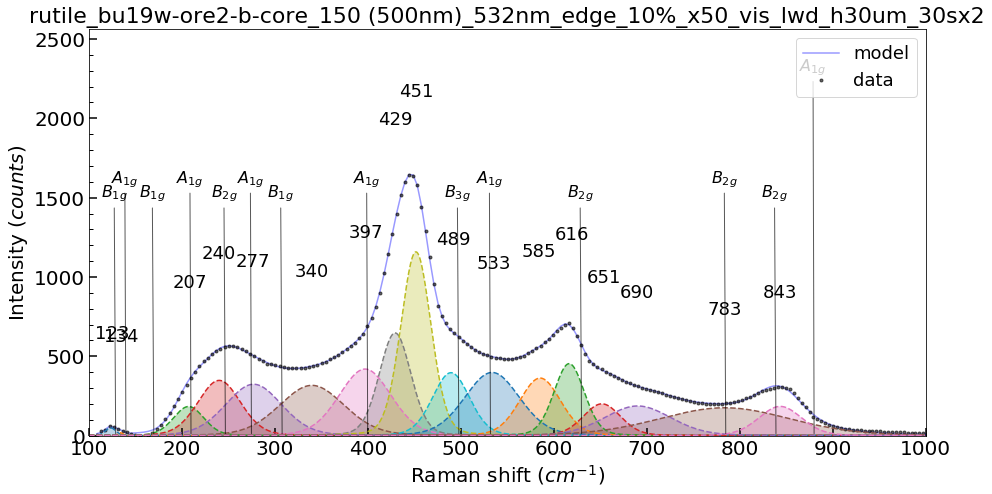

In [68]:
# --- make plot of multiple spectra
for ii in range(len(spectra_files)):
    print(spectra_files[ii])
    spectrum_data(spectra_files[ii])

    df_spectrum_peaks = spectrum_data(spectra_files[ii])
    
        # - set start and end for the plot x axis 

    start = 100 
    end = 1000

    fig, ax = plt.subplots(figsize=(15,7.5))

        # --- RUTILE - add specific annotations for normal modes in the spectrum

    # plt.annotate("$B_{1g}$",xy=(143, 0), xytext=(126, np.percentile(df_spectrum_peaks["Y Value"], 90)),
    #               arrowprops=dict(arrowstyle="-",
    #                               edgecolor = "black",
    #                               linewidth=1,
    #                               alpha=0.65), size = 16)

    # plt.annotate("$E_{g}$",xy=(447, 0), 
    #              xytext=(437, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
    #               arrowprops=dict(arrowstyle="-",
    #                               edgecolor = "black",
    #                               linewidth=1,
    #                               alpha=0.65), size = 16)

    # plt.annotate("$A_{1g}$",xy=(612, 0), 
    #              xytext=(597, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
    #               arrowprops=dict(arrowstyle="-",
    #                               edgecolor = "black",
    #                               linewidth=1,
    #                               alpha=0.65), size = 16)

    # plt.annotate("$B_{2g}$",xy=(826, 0), xytext=(810, np.percentile(df_spectrum_peaks["Y Value"], 90)),
    #               arrowprops=dict(arrowstyle="-",
    #                               edgecolor = "black",
    #                               linewidth=1,
    #                               alpha=0.65), size = 16)

    # plt.text(240, np.percentile(df_spectrum_peaks["Y Value"], 91), 
    #             "Second order \nphonons",horizontalalignment='center',fontsize=16)

        # --- COLTAN - add specific annotations for normal modes in the spectrum

    plt.annotate("$A_{1g}$",xy=(880, 0), 
                 xytext=(864, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 88)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{2g}$",xy=(630, 0), 
                 xytext=(614, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$A_{1g}$",xy=(532, 0), 
                 xytext=(516, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$A_{1g}$",xy=(400, 0), 
                 xytext=(384, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$A_{1g}$",xy=(275, 0), 
                 xytext=(259, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{1g}$",xy=(129, 0), 
                 xytext=(113, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$A_{1g}$",xy=(140, 0), 
                 xytext=(124, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$A_{1g}$",xy=(210, 0), 
                 xytext=(194, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{2g}$",xy=(785, 0), 
                 xytext=(769, np.percentile(df_spectrum_peaks["Y Value"], 99)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{2g}$",xy=(839, 0), 
                 xytext=(823, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{1g}$",xy=(170, 0), 
                 xytext=(154, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{2g}$",xy=(247, 0), 
                 xytext=(231, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{1g}$",xy=(308, 0), 
                 xytext=(292, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

    plt.annotate("$B_{3g}$",xy=(498, 0), 
                 xytext=(482, np.percentile(df_spectrum_peaks["Y Value"], 98)),
                  arrowprops=dict(arrowstyle="-",
                                  edgecolor = "black",
                                  linewidth=1,
                                  alpha=0.65), size = 16)

        # - plot the raw spectrum line (measured data) and the modelled spectrum (after peak fitting)

    plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Predict"],'b-', label='model', alpha=0.4)
    plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Value"],'k.', label='data', alpha=0.6)


        # - plot the modelled center value (Raman shift) of peaks above the curve.
                # plotting the FWHM is also possible by using the commented section   

    for ii in range(df_spectrum_peaks.shape[0]):
        if start < df_spectrum_peaks.iloc[ii]["center"] < end:
            text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
            plt.text(df_spectrum_peaks.iloc[ii]["X Value"]-20,
                     df_spectrum_peaks.iloc[ii]["Y Predict"]+np.percentile(df_spectrum_peaks["Y Predict"], 80),
                     text,fontsize=18)
    #         if np.percentile(df_spectrum_peaks.iloc[ii]["height"], 50) > df_spectrum_peaks.iloc[ii]["center"]:
    #             text = str(int(df_spectrum_peaks.iloc[ii]["FWHM"]))
    #             plt.text(df_spectrum_peaks.iloc[ii]["X Value"]-15,df_spectrum_peaks.iloc[ii]["Y Predict"]+10,text,fontsize=18)

        # - get positions of peak data inside the overall file

    counter = 0
    peak_lines_loc = []

    for value in df_spectrum_peaks['center']:
        if value > 0:
            peak_lines_loc.append(counter)
        counter += 1


        # --- add modelled peaks to plot

    x = np.arange(start,end)

    for peak in peak_lines_loc:
        a_0 = df_spectrum_peaks['height'][peak]
        a_1 = df_spectrum_peaks['a1'][peak]
        a_2 = df_spectrum_peaks['a2'][peak]
        a_3 = df_spectrum_peaks['a3'][peak]
        y = gauss_lor_sum(x, a_0, a_1, a_2, a_3)
        plt.plot(x,y,ls='--')
        ax.fill_between(x, y.min(),y, alpha=0.3)


        # --- adjust plot parameters

    plt.legend(loc='best',fontsize=18)    

    plt.xlabel("Raman shift ($cm^{-1}$)",fontsize=20)
    plt.xlim([start,end])
    plt.ylabel("Intensity ($counts$)",fontsize=20)
    plt.ylim([-5,np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 94)])

    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='major',labelsize=20,direction='in',width=1.5,length=8)
    ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

    plt.title(df_spectrum_peaks.iloc[0]["file"],horizontalalignment='center',fontsize=22)

    # plt.text(start+150, np.percentile(df_spectrum_peaks["Y Value"], 100), 
    #             "$R^2$="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=20)



    # plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+df_spectrum_peaks.iloc[0]["file"]+'_peakfit.pdf')
    plt.show()

In [13]:
df_spectra = pd.DataFrame()

data_dir = 'C:/Users/u0125722/Box Sync/Buranga/_Article2-Buranga_mineral_evolution/Supplementary_files/Supplementary_material-S4-Processed_Raman_spectra/'
raw_files = sorted(os.listdir(data_dir))

print(raw_files)


for ii in range(len(raw_files)):
#     print(spectra_files[ii])
#     print(ii)
    df_a = pd.read_csv(data_dir+raw_files[ii], comment='#', sep='\t',
                       names=['X Value', 'Y Value'])
    
    df_a['file']=raw_files[ii].replace(".dat", "").replace(".txt", "")

    df_spectra = pd.concat([df_spectra,df_a], axis=0, sort=False)
    
    
df_spectra.to_csv('Supplementary_material-S4-Processed_Raman_spectra.csv',index = True)
df_spectra

['albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd_h30um_30sx2_01.txt', 'apatite-F_150 (500nm)_633nm_Edge_50%_x50_VIS_LWD_H100um_15sX2.txt', 'apatite-OH_150 (500nm)_633nm_edge_100%_x50_vis_lwd_h30um_30sx2_01.txt', 'augelite_150 (500nm)_633nm_edge_100%_x50_vis_lwd_h30um_30sx2_01.txt', 'bertossaite_150 (500nm)_633nm_edge_100%_x50_vis_lwd_h30um_30sx2_01.txt', 'beryl_150 (500nm)_633nm_Edge_100%_x50_VIS_LWD_H100um_15sx2.txt', 'brazilianite_150 (500nm)_633nm_Edge_100%_x50_VIS_LWD_H100um_15sX2.txt', 'burangaite_150 (500nm)_532nm_Edge_100%_x100_VIS_H100um_20sX2.txt', 'eosphorite_150 (500nm)_532nm_edge_50%_x50_vis_lwd_h30um_20sx2_01.txt', 'montebrasite-F_150 (500nm)_532nm_Edge_100%_x50_VIS_LWD_H100um_20sX2.txt', 'montebrasite-OH_150 (500nm)_633nm_Edge_50%_x50_VIS_LWD_H100um_15sX2.txt', 'muscovite_150 (500nm)_633nm_edge_100%_x50_vis_lwd_h30um_15sx2_01.txt', 'quartz_150 (500nm)_532nm_Edge_50%_x50_VIS_LWD_H50um_20sX2.txt', 'rosemaryite_150 (500nm)_532nm_edge_25%_x50_vis_lwd_h100um_15sx2_01.txt', 'sa

,X Value,Y Value,file
0,100.764,9.635010,albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd...
1,104.022,-0.269348,albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd...
2,107.281,52.063300,albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd...
3,110.536,218.144000,albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd...
4,113.791,449.659000,albite_150 (500nm)_633nm_edge_100%_x50_vis_lwd...
...,...,...,...
1062,3987.660,3.445510,wyllieite_150 (500nm)_532nm_edge_10%_x50_vis_l...
1063,3990.550,2.295350,wyllieite_150 (500nm)_532nm_edge_10%_x50_vis_l...
1064,3993.440,1.086840,wyllieite_150 (500nm)_532nm_edge_10%_x50_vis_l...
1065,3996.330,-0.030441,wyllieite_150 (500nm)_532nm_edge_10%_x50_vis_l...
